<a href="https://colab.research.google.com/github/LukmaanViscomi/AI-Deep-Learning/blob/main/Baseline_Controlled_V5_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzip The Data

In [ ]:
### Section 1: Setup and Dependencies
!apt-get install p7zip-full # Install 7-Zip
!pip install patool # Install the patool library which provides the patoolib module
import zipfile
import os
import patoolib # Now you can import patoolib

# Path to the uploaded zip file
zip_file_path = '/content/drive/MyDrive/dataset2 (1).zip'
extracted_folder_path = './dataset2'  # Use a relative path for the extraction directory

# Extract the zip file using patool
patoolib.extract_archive(zip_file_path, outdir=extracted_folder_path)

# List the contents of the extracted folder
extracted_files = os.listdir(extracted_folder_path)
print(extracted_files)

### Section 2 : Inspecting the Original Dataset


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 6.6 MB/s eta 0:00:00


INFO patool: Extracting /content/drive/MyDrive/dataset2 (1).zip ...
INFO:patool:Extracting /content/drive/MyDrive/dataset2 (1).zip ...
INFO patool: ... creating output directory `./dataset2'.
INFO:patool:... creating output directory `./dataset2'.
INFO patool: running /usr/bin/7z x -o./dataset2 -- "/content/drive/MyDrive/dataset2 (1).zip"
INFO:patool:running /usr/bin/7z x -o./dataset2 -- "/content/drive/MyDrive/dataset2 (1).zip"
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/drive/MyDrive/dataset2 (1).zip extracted to `./dataset2'.
INFO:patool:... /content/drive/MyDrive/dataset2 (1).zip extracted to `./dataset2'.


['triple_mnist']


### Redistribute The Dataset For Train/Val/Test

In [ ]:
#
import os
import shutil
from pathlib import Path
import random

# Paths to original directories
original_base_dir = Path('dataset2/triple_mnist')
original_train_dir = original_base_dir / 'train'
original_val_dir = original_base_dir / 'val'
original_test_dir = original_base_dir / 'test'

# Path to the new dataset directory
new_base_dir = Path('dataset-c/triple_mnist')
new_train_dir = new_base_dir / 'train'
new_val_dir = new_base_dir / 'val'
new_test_dir = new_base_dir / 'test'

# Ensure the new directories exist
new_train_dir.mkdir(parents=True, exist_ok=True)
new_val_dir.mkdir(parents=True, exist_ok=True)
new_test_dir.mkdir(parents=True, exist_ok=True)

# Function to split and copy files
def split_and_copy_files(src_dir, new_train_dir, new_val_dir, new_test_dir, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    if not src_dir.exists():
        return

    classes = sorted(os.listdir(src_dir))

    for cls in classes:
        cls_path = src_dir / cls
        if cls_path.is_dir():
            images = list(cls_path.glob('*'))
            random.shuffle(images)

            num_train = int(len(images) * train_ratio)
            num_val = int(len(images) * val_ratio)

            train_images = images[:num_train]
            val_images = images[num_train:num_train+num_val]
            test_images = images[num_train+num_val:]

            cls_train_dir = new_train_dir / cls
            cls_val_dir = new_val_dir / cls
            cls_test_dir = new_test_dir / cls

            cls_train_dir.mkdir(parents=True, exist_ok=True)
            cls_val_dir.mkdir(parents=True, exist_ok=True)
            cls_test_dir.mkdir(parents=True, exist_ok=True)

            for img in train_images:
                shutil.copy(str(img), str(cls_train_dir / img.name))
            for img in val_images:
                shutil.copy(str(img), str(cls_val_dir / img.name))
            for img in test_images:
                shutil.copy(str(img), str(cls_test_dir / img.name))

# Split and copy files from original train, val, and test directories
split_and_copy_files(original_train_dir, new_train_dir, new_val_dir, new_test_dir)
split_and_copy_files(original_val_dir, new_train_dir, new_val_dir, new_test_dir)
split_and_copy_files(original_test_dir, new_train_dir, new_val_dir, new_test_dir)

print("Files split and copied successfully!")

Files split and copied successfully!


### Imports and Initial Setup -Define Directory

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Define directories for training and testing datasets
train_dir = os.path.join('/content/dataset-c/triple_mnist/train')
test_dir = os.path.join('/content/dataset-c/triple_mnist/test')
val_dir = os.path.join('/content/dataset-c/triple_mnist/val')

### Data Generators for the Subset

In [ ]:
# Define image size and batch size
image_size = (42, 42)
batch_size = 32

# Create ImageDataGenerator for training (with augmentation if needed) and rescaling for validation/test
train_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True  # Shuffle the data to ensure random order
)

# Load and preprocess validation data
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

val_generator = val_datagen.flow_from_directory(
    val_dir,  # Make sure to define val_dir pointing to your validation directory
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Typically, validation data is not shuffled
)

# Load and preprocess test data
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)




Found 60000 images belonging to 1000 classes.
Found 20000 images belonging to 1000 classes.
Found 20000 images belonging to 1000 classes.


### Build the model

In [ ]:
# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_generator.classes),
                                     y=train_generator.classes)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

#Initialize the model
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(42, 42, 3)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(train_generator.num_classes, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Add a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Train on Full Dataset (RUN 18-8-2024-8:29)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 184s 97ms/step - accuracy: 0.0021 - loss: 6.8372 - val_accuracy: 0.0567 - val_loss: 4.9168 - learning_rate: 0.0010
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 181s 96ms/step - accuracy: 0.0457 - loss: 4.9192 - val_accuracy: 0.2202 - val_loss: 3.1242 - learning_rate: 0.0010
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 180s 96ms/step - accuracy: 0.1336 - loss: 3.6262 - val_accuracy: 0.3354 - val_loss: 2.4478 - learning_rate: 0.0010
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 202s 96ms/step - accuracy: 0.2226 - loss: 2.9381 - val_accuracy: 0.4587 - val_loss: 1.9353 - learning_rate: 0.0010
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 202s 96ms/step - accuracy: 0.3037 - loss: 2.4931 - val_accuracy: 0.5597 - val_loss: 1.5813 - learning_rate: 0.0010
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 180s 96ms/step - accuracy: 0.3880 - loss: 2.1261 - val_accuracy: 0.6424 - val_loss: 1.3157 - learning_rate: 0.0010
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 202s 96ms/step - accuracy: 

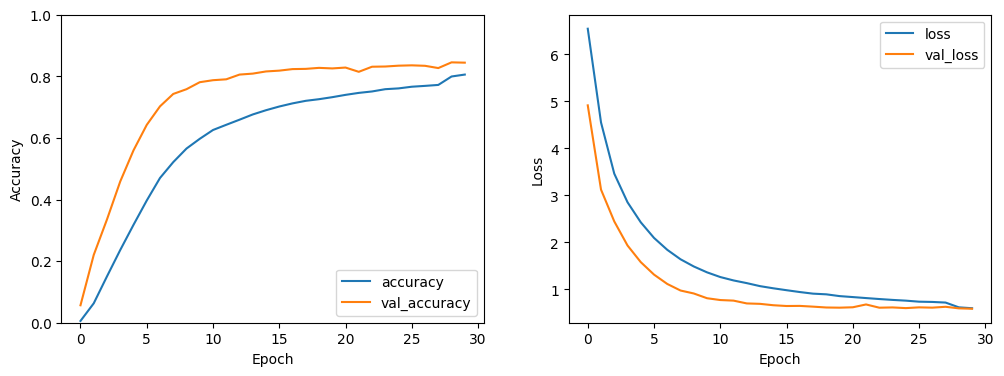

625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.8644 - loss: 0.5323
Test accuracy: 0.849049985408783


In [ ]:

# Train the model
history = cnn_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,  # Use the separate validation data
    class_weight=class_weights,  # Use class weights if needed
    callbacks=[lr_scheduler]
)

# Plot learning curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")
